In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
from scipy.stats import skew, kurtosis, t as student_t, genpareto
import ta   # https://github.com/bukosabino/ta
import mplfinance as mpf

sns.set_theme(context="notebook", style="darkgrid")
plt.rcParams["figure.figsize"] = (12,6)


In [12]:
import pandas as pd
from pathlib import Path

# assume this notebook lives in <project_root>/notebooks/
# so one level up is project_root
project_root = Path.cwd().parent

# merged_data.csv lives in project_root/data/raw/
data_path = project_root / "data" / "raw" / "merged_data.csv"

# now read it
df = pd.read_csv(
    data_path,
    parse_dates=["Date"],
    dayfirst=False,
    infer_datetime_format=True
)
df = df.dropna(subset=["Date"])

# sort and reset
df = df.sort_values(["Ticker", "Date"]).reset_index(drop=True)
df.head()


/var/folders/jq/mbgbv6211m9816f1py7zsb0c0000gn/T/ipykernel_43468/3633781425.py:12: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


,Date,Open,High,Low,Close,Volume,Ticker
0,2022-07-01,133.891901,136.844531,133.517912,136.736267,71051600.0,AAPL
1,2022-07-06,139.118098,141.844349,138.852357,140.663300,74064300.0,AAPL
2,2022-07-07,141.027444,144.235978,141.017607,144.039139,66253700.0,AAPL
3,2022-07-08,142.966354,145.220203,142.710464,144.718246,64547800.0,AAPL
4,2022-07-11,143.369891,144.324576,141.509734,142.582520,63141600.0,AAPL


In [13]:
# data shape & dtypes
print(df.shape)
print(df.dtypes)

# summary stats for numeric columns
display(df.describe().T)


(2253, 7)
Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
Ticker     object
dtype: object


,count,mean,std,min,25%,50%,75%,max
Open,2250.0,1.887858e+02,6.227216e+01,8.489088e+01,1.483691e+02,1.781050e+02,2.231616e+02,4.759000e+02
High,2250.0,1.918018e+02,6.391480e+01,8.600420e+01,1.505636e+02,1.806150e+02,2.253129e+02,4.885400e+02
Low,2250.0,1.858019e+02,6.034750e+01,8.284316e+01,1.462796e+02,1.756860e+02,2.188580e+02,4.575100e+02
Close,2250.0,1.888665e+02,6.212467e+01,8.293262e+01,1.485437e+02,1.780488e+02,2.221086e+02,4.798600e+02
Volume,2250.0,6.792969e+07,4.360468e+07,9.701400e+06,3.407972e+07,5.597225e+07,9.038460e+07,3.186799e+08


In [14]:
desc = df.groupby('Ticker')['Close'].describe().T
desc


Ticker,AAPL,GOOGL,TSLA
count,750.000000,750.000000,750.000000
mean,186.300662,139.328870,240.970031
std,31.568804,31.015212,66.692948
min,123.421257,82.932625,108.099998
25%,163.709686,113.143932,189.664997
50%,183.348312,137.555031,234.910004
75%,213.087715,165.658745,272.055000
max,258.396667,205.893341,479.859985


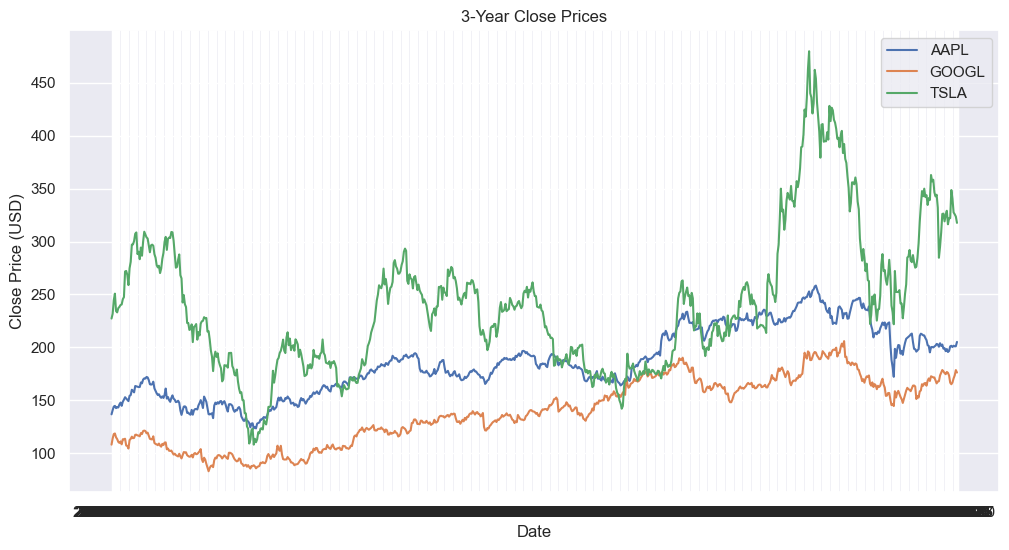

In [15]:
plt.figure()
for t in df['Ticker'].unique():
    sub = df[df['Ticker'] == t]
    plt.plot(sub['Date'], sub['Close'], label=t)
plt.title("3-Year Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()


/var/folders/jq/mbgbv6211m9816f1py7zsb0c0000gn/T/ipykernel_43468/1893660826.py:1: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Ret'] = df.groupby('Ticker')['Close'].pct_change()


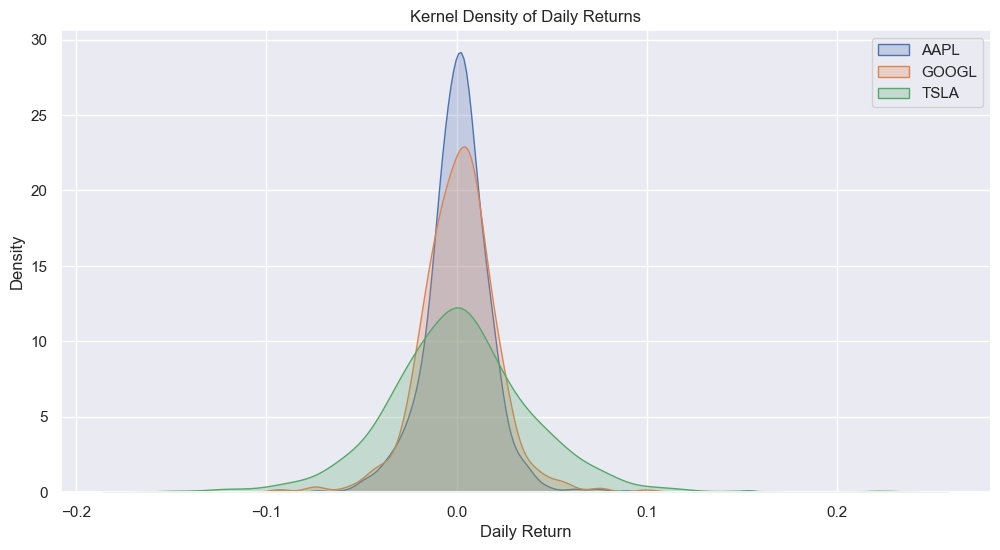

In [16]:
df['Ret'] = df.groupby('Ticker')['Close'].pct_change()

plt.figure()
for t in df['Ticker'].unique():
    rets = df[df['Ticker'] == t]['Ret'].dropna()
    sns.kdeplot(rets, fill=True, label=t)
plt.title("Kernel Density of Daily Returns")
plt.xlabel("Daily Return")
plt.legend()
plt.show()


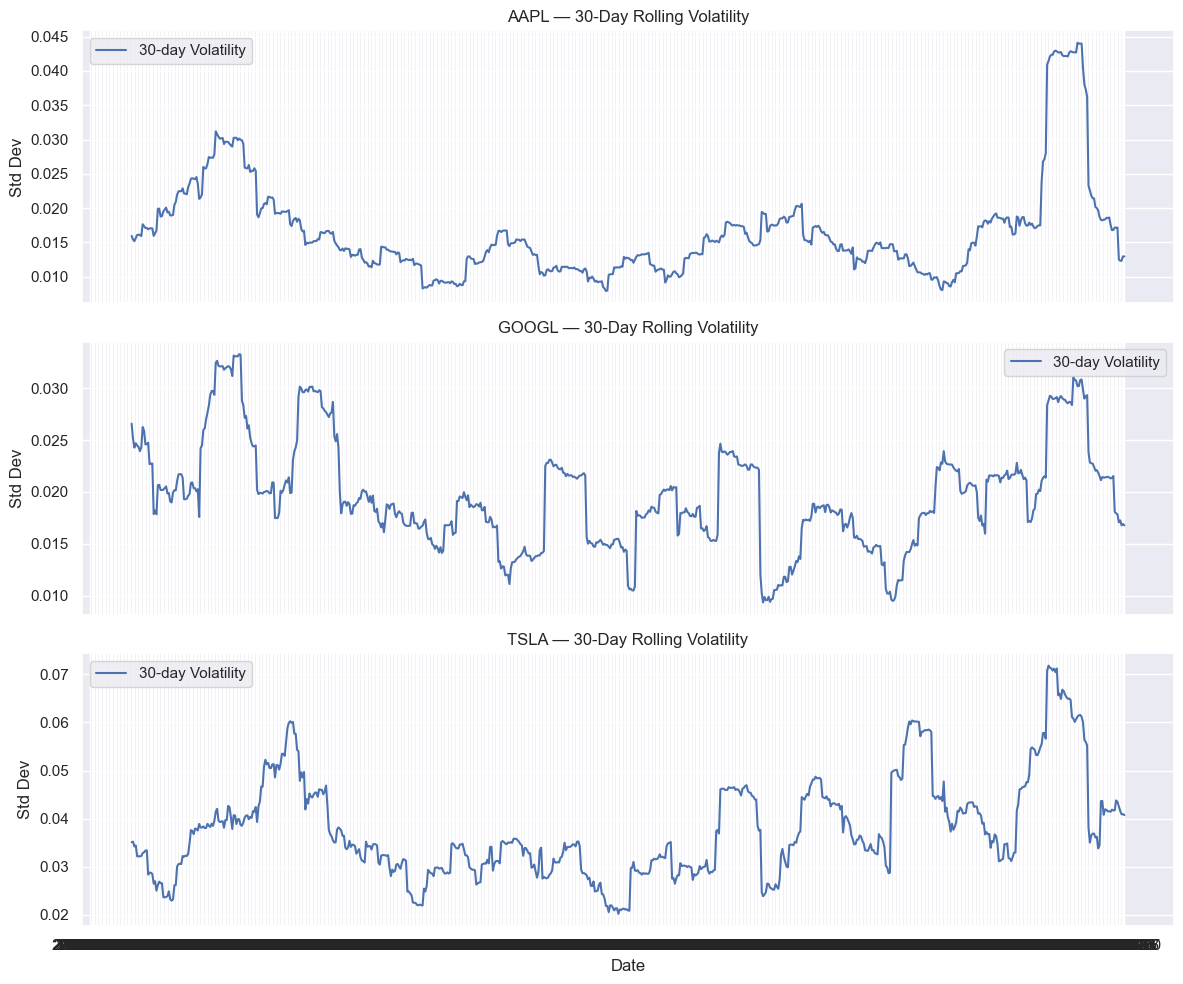

In [17]:
# 30-day rolling std of returns
df["Vol30"] = df.groupby("Ticker")["Ret"].transform(lambda x: x.rolling(30).std())

fig, axes = plt.subplots(3, 1, figsize=(12,10), sharex=True)
for ax, sym in zip(axes, df["Ticker"].unique()):
    sub = df[df["Ticker"]==sym]
    ax.plot(sub["Date"], sub["Vol30"], label="30-day Volatility")
    ax.set_title(f"{sym} — 30-Day Rolling Volatility")
    ax.set_ylabel("Std Dev")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Date")
plt.tight_layout()


In [18]:
print("Ticker | ADF p-value | KPSS p-value")
for t in df['Ticker'].unique():
    series = df[df['Ticker'] == t]['Close'].dropna()
    adf_p = adfuller(series)[1]
    kpss_p = kpss(series, nlags='auto')[1]
    print(f"{t:<6} {adf_p:.4f}      {kpss_p:.4f}")


Ticker | ADF p-value | KPSS p-value
AAPL   0.4597      0.0100
GOOGL  0.7996      0.0100
TSLA   0.3635      0.0100


/var/folders/jq/mbgbv6211m9816f1py7zsb0c0000gn/T/ipykernel_43468/1265328865.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p = kpss(series, nlags='auto')[1]
/var/folders/jq/mbgbv6211m9816f1py7zsb0c0000gn/T/ipykernel_43468/1265328865.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p = kpss(series, nlags='auto')[1]
/var/folders/jq/mbgbv6211m9816f1py7zsb0c0000gn/T/ipykernel_43468/1265328865.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p = kpss(series, nlags='auto')[1]


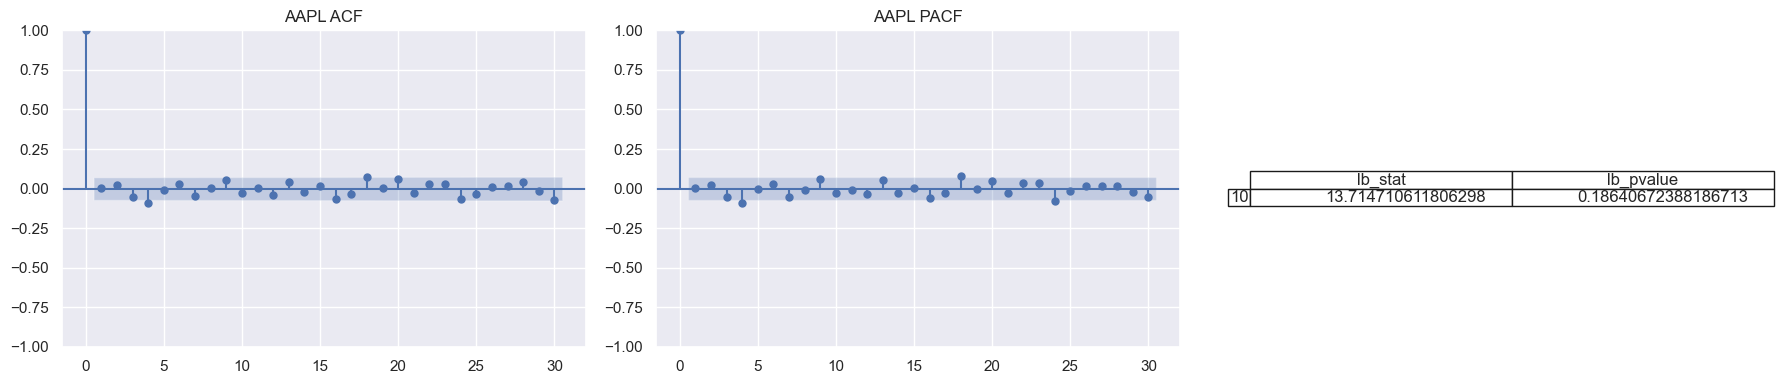

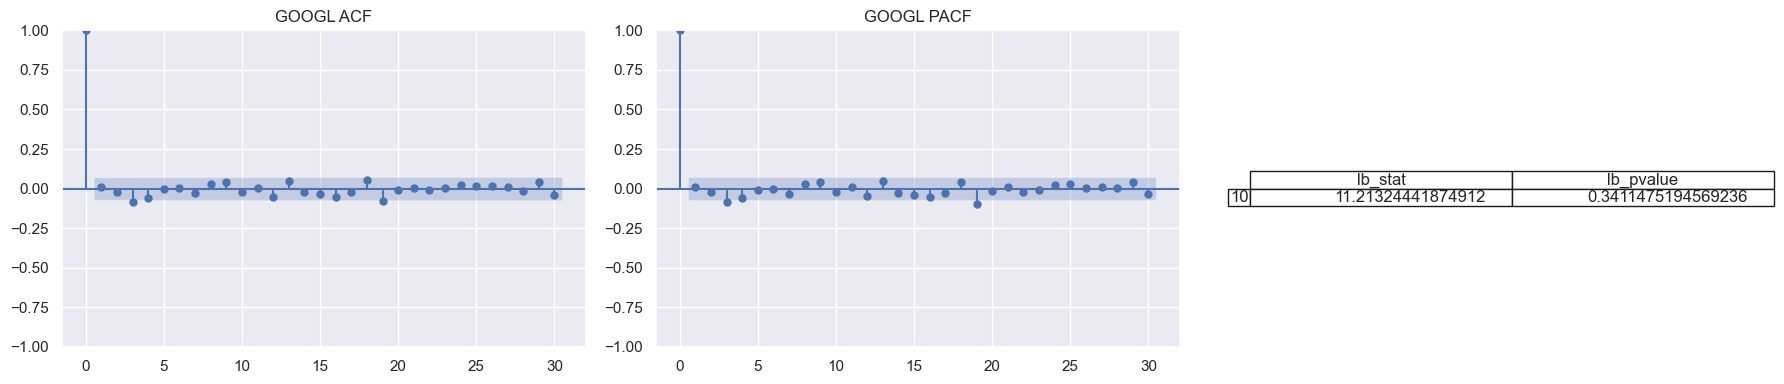

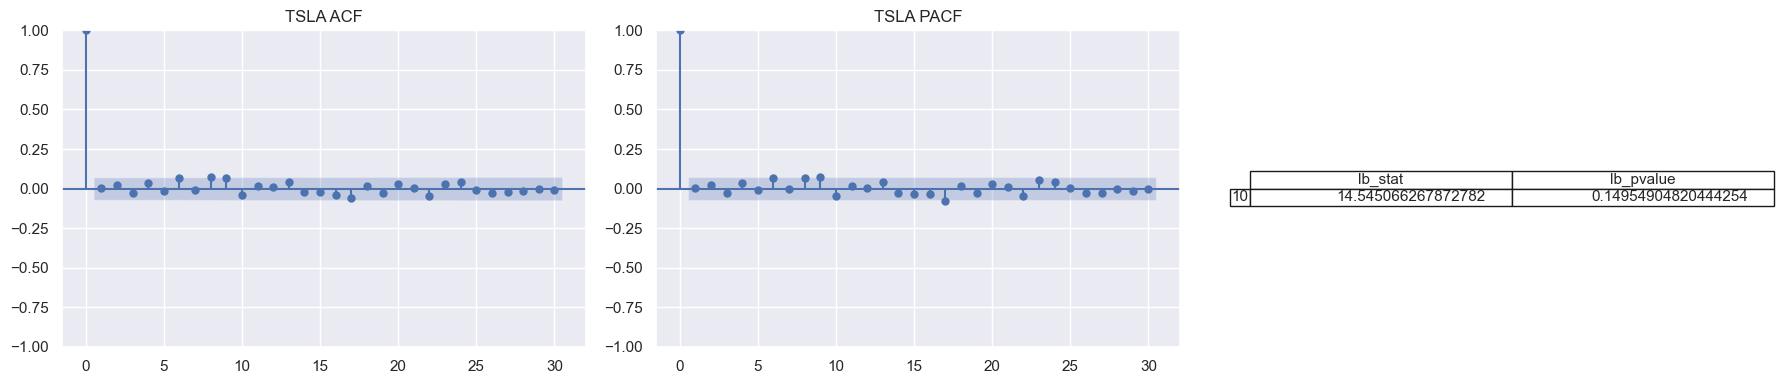

In [19]:
for t in df['Ticker'].unique():
    sub = df[df['Ticker'] == t].copy().dropna(subset=['Ret'])
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    plot_acf(sub['Ret'], lags=30, ax=axes[0], title=f"{t} ACF")
    plot_pacf(sub['Ret'], lags=30, ax=axes[1], title=f"{t} PACF")
    lb = acorr_ljungbox(sub['Ret'], lags=[10], return_df=True)
    axes[2].axis('off')
    axes[2].table(cellText=lb.values, colLabels=lb.columns, rowLabels=lb.index, loc='center')
    plt.tight_layout()
    plt.show()


In [20]:
print("=== GARCH(1,1) Summary ===")
for t in df['Ticker'].unique():
    sub = df[df['Ticker'] == t].copy().dropna(subset=['Ret'])
    rets = sub['Ret'] * 100  # percent returns
    model = arch_model(rets, vol='Garch', p=1, q=1, dist='t')
    res = model.fit(disp='off')
    print(f"\n{t} GARCH(1,1):")
    display(res.summary())


=== GARCH(1,1) Summary ===

AAPL GARCH(1,1):


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                          Ret   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1391.77
Distribution:      Standardized Student's t   AIC:                           2793.54
Method:                  Maximum Likelihood   BIC:                           2816.64
                                              No. Observations:                  750
Date:                      Wed, Jul 30 2025   Df Residuals:                      749
Time:                              20:12:03   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1019  4.986e-02      2.044  4.094e-02 [4.195e-03,  0.200]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0911  5.002e-02      1.822  6.849e-02  [-6.911e-03,  0.189]
alpha[1]       0.0584  1.942e-02      3.008  2.630e-03 [2.036e-02,9.650e-02]
beta[1]        0.9108  2.795e-02     32.582 7.320e-233     [  0.856,  0.966]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.4076      0.662      6.656  2.808e-11 [  3.110,  5.705]
========================================================================

Covariance estimator: robust
"""


GOOGL GARCH(1,1):


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                          Ret   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1539.52
Distribution:      Standardized Student's t   AIC:                           3089.04
Method:                  Maximum Likelihood   BIC:                           3112.14
                                              No. Observations:                  750
Date:                      Wed, Jul 30 2025   Df Residuals:                      749
Time:                              20:12:03   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1342  6.384e-02      2.102  3.552e-02 [9.095e-03,  0.259]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0250  1.591e-02      1.571      0.116 [-6.185e-03,5.619e-02]
alpha[1]       0.0111  6.119e-03      1.819  6.898e-02 [-8.653e-04,2.312e-02]
beta[1]        0.9817  6.657e-03    147.457      0.000      [  0.969,  0.995]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.4602      0.650      6.864  6.699e-12 [  3.187,  5.734]
========================================================================

Covariance estimator: robust
"""


TSLA GARCH(1,1):


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                          Ret   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2046.29
Distribution:      Standardized Student's t   AIC:                           4102.57
Method:                  Maximum Likelihood   BIC:                           4125.67
                                              No. Observations:                  750
Date:                      Wed, Jul 30 2025   Df Residuals:                      749
Time:                              20:12:03   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0294      0.124      0.238      0.812 [ -0.213,  0.272]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.2459      0.259      0.950      0.342     [ -0.261,  0.753]
alpha[1]       0.0271  1.334e-02      2.029  4.244e-02 [9.234e-04,5.320e-02]
beta[1]        0.9587  2.624e-02     36.531 3.556e-292     [  0.907,  1.010]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.6508      0.785      5.924  3.134e-09 [  3.112,  6.189]
========================================================================

Covariance estimator: robust
"""

In [21]:
print("=== Tail Metrics & VaR ===")
for t in df['Ticker'].unique():
    sub = df[df['Ticker'] == t].copy().dropna(subset=['Ret'])
    s_val, k_val = skew(sub['Ret']), kurtosis(sub['Ret'], fisher=False)
    df_t, loc, scale = student_t.fit(sub['Ret'])
    var5 = student_t.ppf(0.05, df_t, loc=loc, scale=scale)
    cvar5 = sub['Ret'][sub['Ret'] < var5].mean()
    thresh = sub['Ret'].quantile(0.95)
    excess = sub['Ret'][sub['Ret'] > thresh] - thresh
    c, loc_p, scale_p = genpareto.fit(excess)
    n, nu = sub.shape[0], excess.shape[0]
    p = 0.95
    var_evt = thresh + (scale_p / c) * (((n*(1-p)/nu))**(-c) - 1)
    print(f"{t}: skew={s_val:.3f}, kurtosis={k_val:.3f}")
    print(f"  Student-t VaR(5%)={var5:.4f}, CVaR={cvar5:.4f}")
    print(f"  EVT VaR(95%)={var_evt:.4f}\n")


=== Tail Metrics & VaR ===
AAPL: skew=0.738, kurtosis=12.784
  Student-t VaR(5%)=-0.0253, CVaR=-0.0371
  EVT VaR(95%)=0.0247

GOOGL: skew=-0.030, kurtosis=6.568
  Student-t VaR(5%)=-0.0303, CVaR=-0.0475
  EVT VaR(95%)=0.0289

TSLA: skew=0.450, kurtosis=6.484
  Student-t VaR(5%)=-0.0610, CVaR=-0.0851
  EVT VaR(95%)=0.0628



In [22]:
def add_technical_indicators(group):
    """Given df for one ticker, add SMA, EMA, MACD, RSI, Bollinger Bands."""
    close = group["Close"]
    vol   = group["Volume"]

    # Simple / Exponential MAs
    group["SMA20"] = close.rolling(20).mean()
    group["SMA50"] = close.rolling(50).mean()
    group["EMA20"] = close.ewm(span=20, adjust=False).mean()

    # MACD
    macd = ta.trend.MACD(close, window_slow=26, window_fast=12, window_sign=9)
    group["MACD"]     = macd.macd()
    group["MACD_sig"] = macd.macd_signal()
    group["MACD_diff"]= macd.macd_diff()

    # RSI
    rsi = ta.momentum.RSIIndicator(close, window=14)
    group["RSI14"] = rsi.rsi()

    # Bollinger Bands
    bb = ta.volatility.BollingerBands(close, window=20, window_dev=2)
    group["BB_mid"]   = bb.bollinger_mavg()
    group["BB_high"]  = bb.bollinger_hband()
    group["BB_low"]   = bb.bollinger_lband()
    group["BB_pct"]   = bb.bollinger_pband()    # % within bands
    group["BB_width"] = bb.bollinger_wband()    # width
    
    group["Roll10Std"] = group["Ret"].rolling(10).std()

    return group

# 5. Apply per‐ticker
df = (
    df
    .groupby("Ticker", group_keys=False)
    .apply(lambda grp: add_technical_indicators(grp.copy()))
    .reset_index(drop=True)
)

df.head()


/var/folders/jq/mbgbv6211m9816f1py7zsb0c0000gn/T/ipykernel_43468/1789345629.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: add_technical_indicators(grp.copy()))


,Date,Open,High,Low,Close,Volume,Ticker,Ret,Vol30,SMA20,...,MACD,MACD_sig,MACD_diff,RSI14,BB_mid,BB_high,BB_low,BB_pct,BB_width,Roll10Std
0,2022-07-01,133.891901,136.844531,133.517912,136.736267,71051600.0,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-07-06,139.118098,141.844349,138.852357,140.663300,74064300.0,AAPL,0.028720,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-07-07,141.027444,144.235978,141.017607,144.039139,66253700.0,AAPL,0.023999,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-07-08,142.966354,145.220203,142.710464,144.718246,64547800.0,AAPL,0.004715,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-07-11,143.369891,144.324576,141.509734,142.582520,63141600.0,AAPL,-0.014758,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


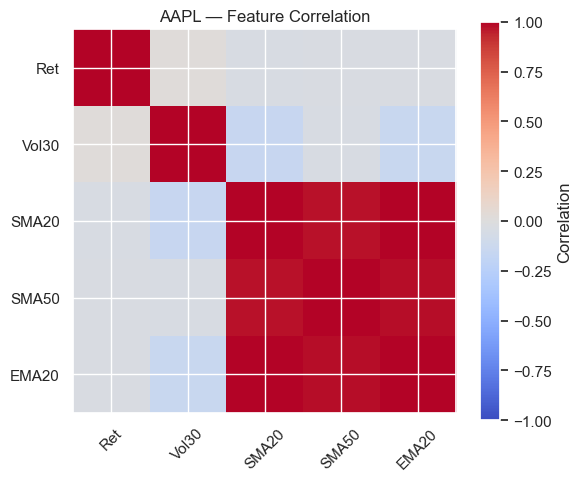

In [23]:


# pick one ticker, latest period
sym = df["Ticker"].unique()[0]
sub = df[df["Ticker"]==sym][["Ret","Vol30","SMA20","SMA50","EMA20"]].dropna()

corr = sub.corr()

plt.figure(figsize=(6,5))
plt.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar(label="Correlation")
plt.xticks(np.arange(len(corr)), corr.columns, rotation=45)
plt.yticks(np.arange(len(corr)), corr.index)
plt.title(f"{sym} — Feature Correlation")
plt.tight_layout()


Matplotlib is building the font cache; this may take a moment.


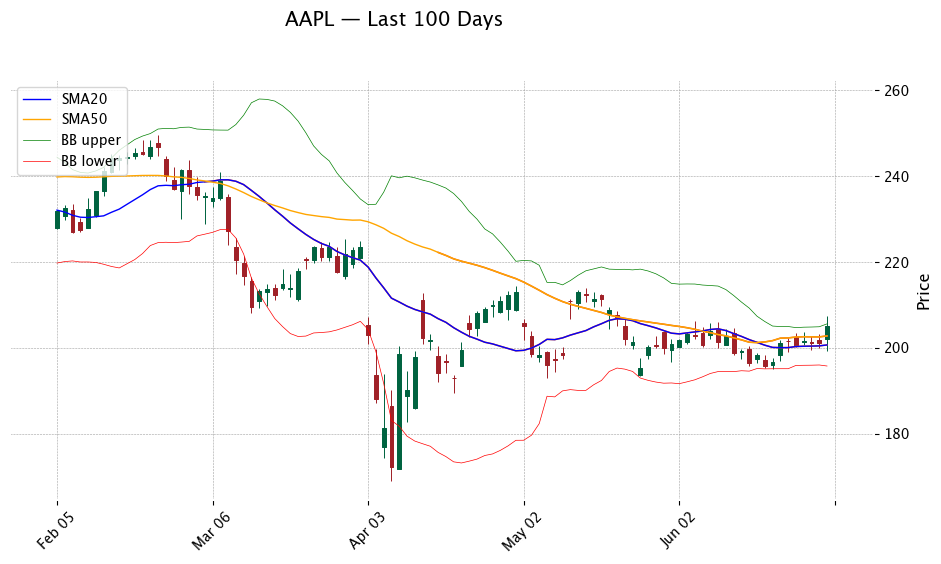

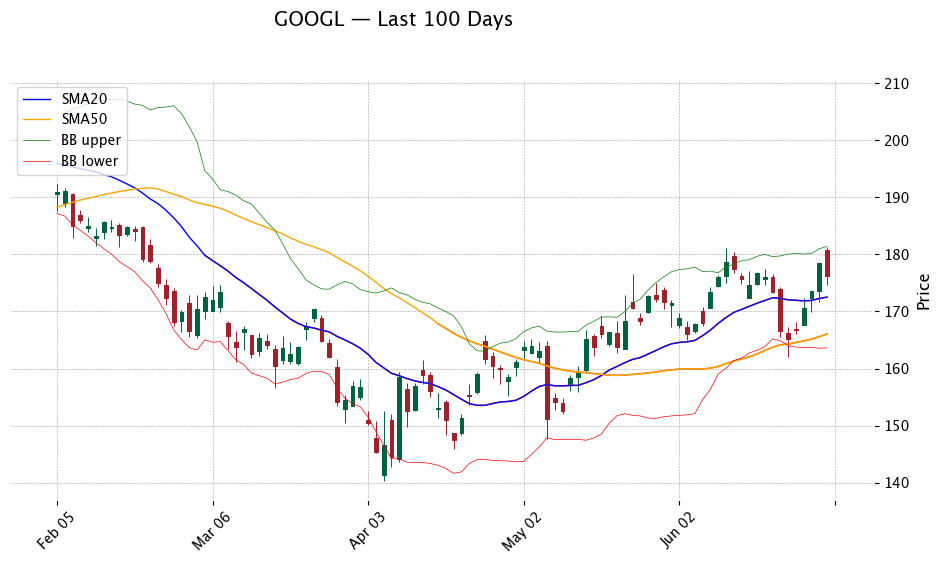

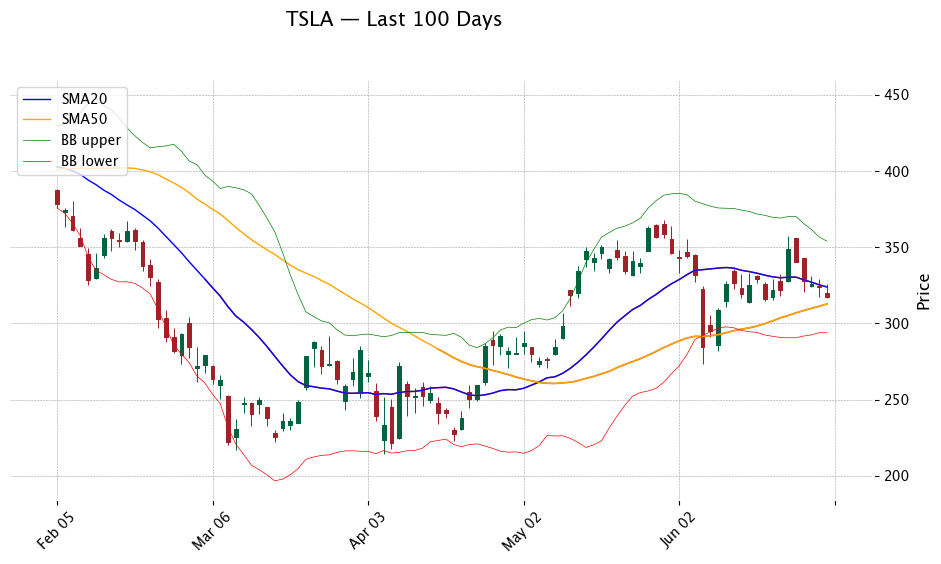

In [24]:



# Parameters
window  = 100
symbols = df['Ticker'].unique()

for symbol in symbols:
    # 1) Subset & index
    o = df[df['Ticker'] == symbol].copy()
    o['Date'] = pd.to_datetime(o['Date'], errors='coerce')
    o = o.dropna(subset=['Date'])
    o = o.sort_values('Date').set_index('Date')
    if window is not None:
        o = o.iloc[-window:]
    
    # 2) Price candles
    candles = o[['Open','High','Low','Close']]
    
    # 3) Overlays with labels
    add_plots = [
        mpf.make_addplot(o['SMA20'],   panel=0, color='blue',   width=1, label='SMA20'),
        mpf.make_addplot(o['SMA50'],   panel=0, color='orange', width=1, label='SMA50'),
        mpf.make_addplot(o['BB_high'], panel=0, color='green',  width=0.5, label='BB upper'),
        mpf.make_addplot(o['BB_low'],  panel=0, color='red',    width=0.5, label='BB lower'),
    ]
    
    # 4) Plot & grab fig/axes
    fig, axes = mpf.plot(
        candles,
        type='candle',
        style='charles',
        title=f"{symbol} — Last {window} Days",
        volume=False,
        mav=(20,50),        # will draw SMA20 & SMA50 too
        addplot=add_plots,
        returnfig=True,     # return (fig, axes)
        figsize=(12,6)
    )
    
    # 5) Add legend on the main panel (axes[0])
    axes[0].legend(loc='upper left')
    plt.show()
    


In [25]:
df = df.dropna(
    subset=["Ret","SMA20","SMA50","EMA20","BB_high","BB_low","Roll10Std"]
).reset_index(drop=True)
out_path = project_root / "data" / "processed" / "data_with_features.csv"
df.to_csv(out_path, index=False)
print("Features saved to:", out_path)

ModuleNotFoundError: No module named 'pandas.io.formats.csvs'